In [30]:
import numpy as np
import pandas as pd
import os

%matplotlib inline
import matplotlib.pyplot as plt
from pathlib import Path
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Input
import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv("/Users/demo/Desktop/COGS118B_WI_24/Project/archive/ISIC_2019_Training_GroundTruth.csv", header = 0)
lesion_type_dict = {
    'NV': 'Melanocytic nevi',
    'MEL': 'Melanoma',
    'BKL': 'Benign keratosis ',
    'BCC': 'Basal cell carcinoma',
    'AK': 'Actinic keratoses',
    'VASC': 'Vascular lesions',
    'DF': 'Dermatofibroma',
    'SCC' : 'Squamous cell carcinoma'
}
data['truth'] = data.drop(columns='image').idxmax(axis=1)
data.head(20)

,image,MEL,NV,BCC,AK,BKL,DF,VASC,SCC,UNK,truth
0,ISIC_0000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NV
1,ISIC_0000001,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NV
2,ISIC_0000002,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,MEL
3,ISIC_0000003,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NV
4,ISIC_0000004,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,MEL
5,ISIC_0000006,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NV
6,ISIC_0000007,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NV
7,ISIC_0000008,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NV
8,ISIC_0000009,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NV
9,ISIC_0000010,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NV


In [3]:
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
for device in gpu_devices:
    tf.config.experimental.set_memory_growth(device, True)

In [4]:
def load_data(path: str):
    dir = Path(path)
    filepaths = list(dir.glob(r'**/*.jpg'))
    labels = data['truth']
    filepaths = pd.Series(filepaths, name='FilePaths').astype(str)
    labels = pd.Series(labels, name='Labels').astype(str)
    df = pd.merge(filepaths, labels, right_index=True, left_index=True)
    return df.sample(frac=1).reset_index(drop=True)
df = load_data('/Users/demo/Desktop/COGS118B_WI_24/Project/archive/ISIC_2019_Training_Input/ISIC_2019_Training_Input')

In [5]:
df.head(20)

,FilePaths,Labels
0,/Users/demo/Desktop/COGS118B_WI_24/Project/arc...,BCC
1,/Users/demo/Desktop/COGS118B_WI_24/Project/arc...,NV
2,/Users/demo/Desktop/COGS118B_WI_24/Project/arc...,BCC
3,/Users/demo/Desktop/COGS118B_WI_24/Project/arc...,MEL
4,/Users/demo/Desktop/COGS118B_WI_24/Project/arc...,NV
5,/Users/demo/Desktop/COGS118B_WI_24/Project/arc...,MEL
6,/Users/demo/Desktop/COGS118B_WI_24/Project/arc...,NV
7,/Users/demo/Desktop/COGS118B_WI_24/Project/arc...,NV
8,/Users/demo/Desktop/COGS118B_WI_24/Project/arc...,BKL
9,/Users/demo/Desktop/COGS118B_WI_24/Project/arc...,DF


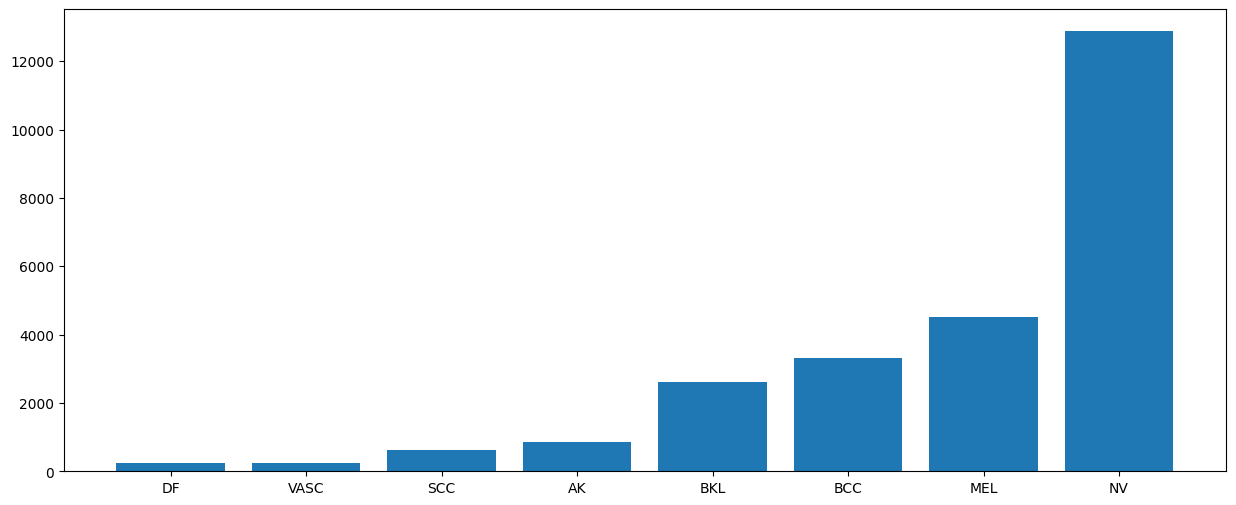

In [6]:
labels_count = df['Labels'].value_counts(ascending=True)

plt.figure(figsize=(15, 6))
plt.bar(labels_count.index, labels_count.values)
plt.show()

In [7]:
df['Labels'] = df['Labels'].apply(lambda x: x if x == 'NV' else 'OTH')
df_binary = df['Labels']
binary = np.array([-1 if x == 'OTH' else 1 for x in df_binary])
binary.shape

(25331,)

We can see that our data is heavily biased towards NV, and has low numbers of other diseases

In [8]:
files = pd.read_csv('archive/ISIC_2019_Training_GroundTruth.csv')
files

,image,MEL,NV,BCC,AK,BKL,DF,VASC,SCC,UNK
0,ISIC_0000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,ISIC_0000001,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,ISIC_0000002,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,ISIC_0000003,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,ISIC_0000004,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
25326,ISIC_0073247,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
25327,ISIC_0073248,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
25328,ISIC_0073249,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25329,ISIC_0073251,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
filesWithLabels = pd.DataFrame()
filesWithLabels['file'] = files['image']+'.jpg'
filesWithLabels['label'] = ""

In [10]:
filesWithLabels['label'] = data['truth']
filesWithLabels['file'] = 'archive/ISIC_2019_Training_Input/ISIC_2019_Training_Input/'+filesWithLabels['file']

In [29]:
X_train, X_test = train_test_split(filesWithLabels, test_size=0.2, random_state=42)

In [31]:
X_train

,file,label
24937,archive/ISIC_2019_Training_Input/ISIC_2019_Tra...,AK
12362,archive/ISIC_2019_Training_Input/ISIC_2019_Tra...,NV
4223,archive/ISIC_2019_Training_Input/ISIC_2019_Tra...,NV
1355,archive/ISIC_2019_Training_Input/ISIC_2019_Tra...,NV
16166,archive/ISIC_2019_Training_Input/ISIC_2019_Tra...,BCC
...,...,...
21575,archive/ISIC_2019_Training_Input/ISIC_2019_Tra...,NV
5390,archive/ISIC_2019_Training_Input/ISIC_2019_Tra...,NV
860,archive/ISIC_2019_Training_Input/ISIC_2019_Tra...,MEL
15795,archive/ISIC_2019_Training_Input/ISIC_2019_Tra...,NV


In [52]:
epochs = 5
input_shape = (512, 512, 3)
num_classes = 1
def get_model():   

    model = Sequential([
        Input(shape=(512, 512, 3)),
        Conv2D(16, kernel_size=(3, 3), input_shape=input_shape, activation="relu", padding="same"),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),
        Dropout(0.2),
        Conv2D(32, kernel_size=(3, 3), activation="relu"),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),
        Dropout(0.2),
        Conv2D(64, kernel_size=(3, 3), activation="relu"),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),
        Dropout(0.2),
        Conv2D(128, kernel_size=(3, 3), activation="relu"),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),
        Dropout(0.2),
        Conv2D(256, kernel_size=(3, 3), activation="relu"),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),
        Dropout(0.2),
        Flatten(),
        Dense(1, activation="sigmoid")
    ])
    return model

In [66]:
datagen = ImageDataGenerator(
    #rescale=1./255,
    validation_split=0.2,
    rotation_range=20,  
    width_shift_range=0.2, 
    height_shift_range=0.2,
    horizontal_flip=True, 
    vertical_flip=True,
    fill_mode="nearest",
)
def plot_history(history, title):
    
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.title(title)
    plt.show()

In [76]:
def conver_models(model,name):
    dest_folder = '/kaggle/working/'
    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    converter.optimizations = [tf.lite.Optimize.DEFAULT]
    tflite_model = converter.convert()
    with open(dest_folder  + name +".tflite", 'wb') as f:
        f.write(tflite_model)
def create_model(table, name, epoch):
    early_stop = EarlyStopping(monitor='val_loss', patience=5)
    train_generator = datagen.flow_from_dataframe(
        dataframe=table,
        directory=None,
        x_col='file',
        y_col='label',
        subset="training",
        batch_size=64,
        seed=42,
        shuffle=True,
        class_mode="binary",
        target_size=(512, 512))
    val_generator = datagen.flow_from_dataframe(
        dataframe=table,
        directory=None,
        x_col='file',
        y_col='label',
        subset="training",
        batch_size=64,
        seed=42,
        shuffle=True,
        class_mode="binary",
        target_size=(512, 512))
    model = get_model()
    model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])
    history = model.fit(train_generator, epochs=epoch, validation_data=val_generator, callbacks=[early_stop])
    return history, model     

In [77]:
NVTable = pd.concat([X_train.loc[X_train['label'] != 'NV'].sample(n=8000), X_train.loc[X_train['label'] == 'NV']])
NVTable['label'] = NVTable['label'].apply(lambda x: 'OTH' if x != 'NV' else x)

n = X_train.loc[X_train['label'] == 'MEL'].shape[0]
MELTable = pd.concat([X_train.loc[X_train['label'] != 'MEL'].sample(n=n), X_train.loc[X_train['label'] == 'MEL']])
MELTable['label'] = MELTable['label'].apply(lambda x: 'OTH' if x != 'MEL' else x)

n = X_train.loc[X_train['label'] == 'BKL'].shape[0]
BKLTable = pd.concat([X_train.loc[X_train['label'] != 'BKL'].sample(n=n), X_train.loc[X_train['label'] == 'BKL']])
BKLTable['label'] = BKLTable['label'].apply(lambda x: 'OTH' if x != 'BKL' else x)

n = X_train.loc[X_train['label'] == 'DF'].shape[0]
DFTable = pd.concat([X_train.loc[X_train['label'] != 'DF'].sample(n=n), X_train.loc[X_train['label'] == 'DF']])
DFTable['label'] = DFTable['label'].apply(lambda x: 'OTH' if x != 'DF' else x)

n = X_train.loc[X_train['label'] == 'SCC'].shape[0]
SCCTable = pd.concat([X_train.loc[X_train['label'] != 'SCC'].sample(n=n), X_train.loc[X_train['label'] == 'SCC']])
SCCTable['label'] = SCCTable['label'].apply(lambda x: 'OTH' if x != 'SCC' else x)

n = X_train.loc[X_train['label'] == 'BCC'].shape[0]
BCCTable = pd.concat([X_train.loc[X_train['label'] != 'BCC'].sample(n=n), X_train.loc[X_train['label'] == 'BCC']])
BCCTable['label'] = BCCTable['label'].apply(lambda x: 'OTH' if x != 'BCC' else x)

n = X_train.loc[X_train['label'] == 'VASC'].shape[0]
VASCTable = pd.concat([X_train.loc[filesWithLabels['label'] != 'VASC'].sample(n=n), X_train.loc[X_train['label'] == 'VASC']])
VASCTable['label'] = VASCTable['label'].apply(lambda x: 'OTH' if x != 'VASC' else x)

n = X_train.loc[X_train['label'] == 'AK'].shape[0]
AKTable = pd.concat([X_train.loc[X_train['label'] != 'AK'].sample(n=n), X_train.loc[X_train['label'] == 'AK']])
AKTable['label'] = AKTable['label'].apply(lambda x: 'OTH' if x != 'AK' else x)

tables = {
    "AK": AKTable,
    "NV": NVTable,
    "MEL": MELTable,
    "BKL": BKLTable,
    "DF": DFTable,
    "SCC": SCCTable,
    "BCC": BCCTable,
    "VASC": VASCTable,

}

In [78]:
NVTable_test = pd.concat([X_test.loc[X_test['label'] != 'NV'].sample(n=1000), X_test.loc[X_test['label'] == 'NV']])
NVTable_test['label'] = NVTable_test['label'].apply(lambda x: 'OTH' if x != 'NV' else x)

n = X_test.loc[X_test['label'] == 'MEL'].shape[0]
MELTable_test = pd.concat([X_test.loc[X_test['label'] != 'MEL'].sample(n=n), X_test.loc[X_test['label'] == 'MEL']])
MELTable_test['label'] = MELTable_test['label'].apply(lambda x: 'OTH' if x != 'MEL' else x)

n = X_test.loc[X_test['label'] == 'BKL'].shape[0]
BKLTable_test = pd.concat([X_test.loc[X_test['label'] != 'BKL'].sample(n=n), X_test.loc[X_test['label'] == 'BKL']])
BKLTable_test['label'] = BKLTable_test['label'].apply(lambda x: 'OTH' if x != 'BKL' else x)

n = X_test.loc[X_test['label'] == 'DF'].shape[0]
DFTable_test = pd.concat([X_test.loc[X_test['label'] != 'DF'].sample(n=n), X_test.loc[X_test['label'] == 'DF']])
DFTable_test['label'] = DFTable_test['label'].apply(lambda x: 'OTH' if x != 'DF' else x)

n = X_test.loc[X_test['label'] == 'SCC'].shape[0]
SCCTable_test = pd.concat([X_test.loc[X_test['label'] != 'SCC'].sample(n=n), X_test.loc[X_test['label'] == 'SCC']])
SCCTable_test['label'] = SCCTable_test['label'].apply(lambda x: 'OTH' if x != 'SCC' else x)

n = X_test.loc[X_test['label'] == 'BCC'].shape[0]
BCCTable_test = pd.concat([X_test.loc[X_test['label'] != 'BCC'].sample(n=n), X_test.loc[X_test['label'] == 'BCC']])
BCCTable_test['label'] = BCCTable_test['label'].apply(lambda x: 'OTH' if x != 'BCC' else x)

n = X_test.loc[X_test['label'] == 'VASC'].shape[0]
VASCTable_test = pd.concat([X_test.loc[X_test['label'] != 'VASC'].sample(n=n), X_test.loc[X_test['label'] == 'VASC']])
VASCTable_test['label'] = VASCTable_test['label'].apply(lambda x: 'OTH' if x != 'VASC' else x)

n = X_test.loc[X_test['label'] == 'AK'].shape[0]
AKTable_test = pd.concat([X_test.loc[X_test['label'] != 'AK'].sample(n=n), X_test.loc[X_test['label'] == 'AK']])
AKTable_test['label'] = AKTable_test['label'].apply(lambda x: 'OTH' if x != 'AK' else x)

tables_test = {
    "AK": AKTable_test,
    "NV": NVTable_test,
    "MEL": MELTable_test,
    "BKL": BKLTable_test,
    "DF": DFTable_test,
    "SCC": SCCTable_test,
    "BCC": BCCTable_test,
    "VASC": VASCTable_test,

}

Found 1104 validated image filenames belonging to 2 classes.


Found 1104 validated image filenames belonging to 2 classes.


/Users/demo/anaconda3/envs/COGS118B_WI24/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/3


/Users/demo/anaconda3/envs/COGS118B_WI24/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
2024-03-20 10:24:36.925727: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:364: Filling up shuffle buffer (this may take a while): 2 of 8
2024-03-20 10:24:48.609862: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:364: Filling up shuffle buffer (this may take a while): 4 of 8
2024-03-20 10:25:06.957428: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:364: Filling up shuffle buffer (this may take a while): 7 of 8
2024-03-20 10:25:12.611999: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer 

18/18 ━━━━━━━━━━━━━━━━━━━━ 356s 17s/step - accuracy: 0.6064 - loss: 4.6403 - val_accuracy: 0.6322 - val_loss: 6.1654
Epoch 2/3


2024-03-20 10:30:26.186407: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:364: Filling up shuffle buffer (this may take a while): 2 of 8
2024-03-20 10:30:46.447789: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:364: Filling up shuffle buffer (this may take a while): 6 of 8
2024-03-20 10:30:56.838171: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


18/18 ━━━━━━━━━━━━━━━━━━━━ 327s 16s/step - accuracy: 0.6508 - loss: 2.2441 - val_accuracy: 0.5100 - val_loss: 1.9056
Epoch 3/3


2024-03-20 10:35:52.867529: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:364: Filling up shuffle buffer (this may take a while): 2 of 8
2024-03-20 10:36:03.823913: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:364: Filling up shuffle buffer (this may take a while): 4 of 8
2024-03-20 10:36:13.989420: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:364: Filling up shuffle buffer (this may take a while): 6 of 8
2024-03-20 10:36:24.044740: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


18/18 ━━━━━━━━━━━━━━━━━━━━ 324s 16s/step - accuracy: 0.6434 - loss: 2.1245 - val_accuracy: 0.4538 - val_loss: 2.0236
Found 354 validated image filenames belonging to 2 classes.


/Users/demo/anaconda3/envs/COGS118B_WI24/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


12/12 ━━━━━━━━━━━━━━━━━━━━ 36s 3s/step - accuracy: 0.7586 - loss: 0.8355
Test Loss: 1.6837960481643677, Test Accuracy: 0.5141242742538452


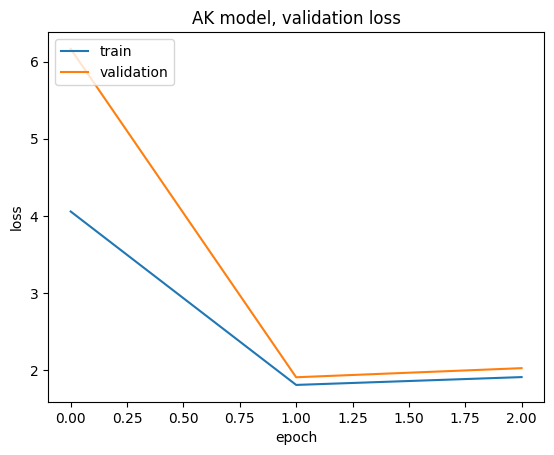

Found 14647 validated image filenames belonging to 2 classes.
Found 14647 validated image filenames belonging to 2 classes.


/Users/demo/anaconda3/envs/COGS118B_WI24/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/3


/Users/demo/anaconda3/envs/COGS118B_WI24/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
2024-03-20 10:42:12.139962: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:384: Filling up shuffle buffer (this may take a while): 2 of 8
2024-03-20 10:42:22.323715: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:384: Filling up shuffle buffer (this may take a while): 4 of 8
2024-03-20 10:42:32.502238: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:384: Filling up shuffle buffer (this may take a while): 6 of 8
2024-03-20 10:42:42.727285: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer 

229/229 ━━━━━━━━━━━━━━━━━━━━ 3725s 16s/step - accuracy: 0.6380 - loss: 2.2388 - val_accuracy: 0.7378 - val_loss: 0.5915
Epoch 2/3


2024-03-20 11:44:13.879261: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:384: Filling up shuffle buffer (this may take a while): 2 of 8
2024-03-20 11:44:23.906669: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:384: Filling up shuffle buffer (this may take a while): 4 of 8
2024-03-20 11:44:43.900020: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


229/229 ━━━━━━━━━━━━━━━━━━━━ 3657s 16s/step - accuracy: 0.7161 - loss: 1.0498 - val_accuracy: 0.7243 - val_loss: 0.7475
Epoch 3/3


2024-03-20 12:45:11.752315: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:384: Filling up shuffle buffer (this may take a while): 2 of 8
2024-03-20 12:45:22.137506: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:384: Filling up shuffle buffer (this may take a while): 4 of 8
2024-03-20 12:45:32.697720: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:384: Filling up shuffle buffer (this may take a while): 6 of 8
2024-03-20 12:45:43.138780: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


229/229 ━━━━━━━━━━━━━━━━━━━━ 3827s 17s/step - accuracy: 0.7272 - loss: 1.0686 - val_accuracy: 0.7490 - val_loss: 0.8591
Found 3567 validated image filenames belonging to 2 classes.


/Users/demo/anaconda3/envs/COGS118B_WI24/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


112/112 ━━━━━━━━━━━━━━━━━━━━ 354s 3s/step - accuracy: 0.6487 - loss: 1.1154
Test Loss: 0.8155665397644043, Test Accuracy: 0.7502102851867676


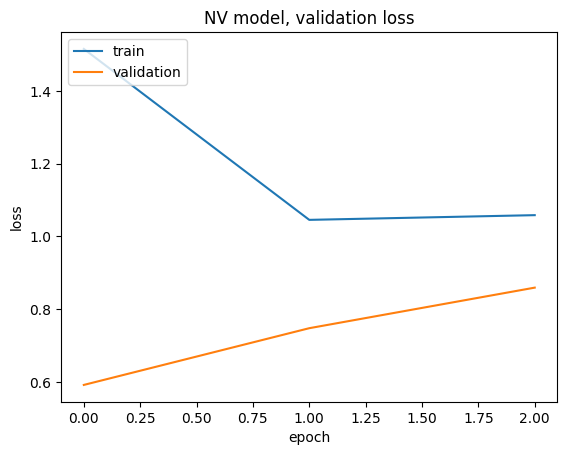

Found 5772 validated image filenames belonging to 2 classes.
Found 5772 validated image filenames belonging to 2 classes.


/Users/demo/anaconda3/envs/COGS118B_WI24/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/3


/Users/demo/anaconda3/envs/COGS118B_WI24/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
2024-03-20 13:55:15.433592: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:404: Filling up shuffle buffer (this may take a while): 2 of 8
2024-03-20 13:55:26.893551: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:404: Filling up shuffle buffer (this may take a while): 4 of 8
2024-03-20 13:55:38.123640: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:404: Filling up shuffle buffer (this may take a while): 6 of 8
2024-03-20 13:55:49.918007: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer 

91/91 ━━━━━━━━━━━━━━━━━━━━ 1568s 17s/step - accuracy: 0.5705 - loss: 3.8657 - val_accuracy: 0.3794 - val_loss: 1.9357
Epoch 2/3


2024-03-20 14:21:18.836421: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:404: Filling up shuffle buffer (this may take a while): 2 of 8
2024-03-20 14:21:29.447194: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:404: Filling up shuffle buffer (this may take a while): 4 of 8
2024-03-20 14:21:48.700466: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


91/91 ━━━━━━━━━━━━━━━━━━━━ 1450s 16s/step - accuracy: 0.6273 - loss: 1.2543 - val_accuracy: 0.5327 - val_loss: 0.8580
Epoch 3/3


2024-03-20 14:45:32.801109: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:404: Filling up shuffle buffer (this may take a while): 3 of 8
2024-03-20 14:45:52.680266: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:404: Filling up shuffle buffer (this may take a while): 7 of 8
2024-03-20 14:45:57.617216: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


91/91 ━━━━━━━━━━━━━━━━━━━━ 1485s 16s/step - accuracy: 0.6593 - loss: 1.2272 - val_accuracy: 0.5473 - val_loss: 0.7875
Found 1830 validated image filenames belonging to 2 classes.


/Users/demo/anaconda3/envs/COGS118B_WI24/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


58/58 ━━━━━━━━━━━━━━━━━━━━ 177s 3s/step - accuracy: 0.7495 - loss: 0.5425
Test Loss: 0.6940799951553345, Test Accuracy: 0.6109289526939392


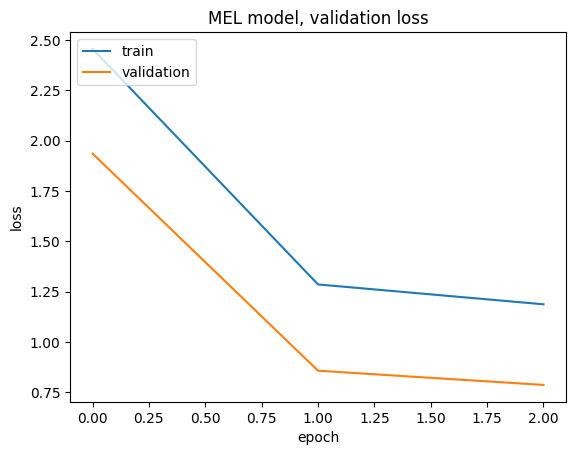

Found 3341 validated image filenames belonging to 2 classes.
Found 3341 validated image filenames belonging to 2 classes.


/Users/demo/anaconda3/envs/COGS118B_WI24/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/3


/Users/demo/anaconda3/envs/COGS118B_WI24/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
2024-03-20 15:13:30.141780: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:424: Filling up shuffle buffer (this may take a while): 2 of 8
2024-03-20 15:13:40.304266: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:424: Filling up shuffle buffer (this may take a while): 4 of 8
2024-03-20 15:13:50.423143: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:424: Filling up shuffle buffer (this may take a while): 6 of 8
2024-03-20 15:14:00.586215: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer 

53/53 ━━━━━━━━━━━━━━━━━━━━ 897s 16s/step - accuracy: 0.5426 - loss: 3.3537 - val_accuracy: 0.3771 - val_loss: 2.2709
Epoch 2/3


2024-03-20 15:28:28.041493: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:424: Filling up shuffle buffer (this may take a while): 3 of 8
2024-03-20 15:28:38.106958: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:424: Filling up shuffle buffer (this may take a while): 5 of 8
2024-03-20 15:28:52.902610: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


53/53 ━━━━━━━━━━━━━━━━━━━━ 884s 16s/step - accuracy: 0.5956 - loss: 1.4715 - val_accuracy: 0.3849 - val_loss: 1.0484
Epoch 3/3


2024-03-20 15:43:11.645501: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:424: Filling up shuffle buffer (this may take a while): 3 of 8
2024-03-20 15:43:30.392707: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:424: Filling up shuffle buffer (this may take a while): 7 of 8
2024-03-20 15:43:35.169585: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


53/53 ━━━━━━━━━━━━━━━━━━━━ 869s 16s/step - accuracy: 0.6283 - loss: 1.5759 - val_accuracy: 0.6456 - val_loss: 0.8270
Found 1072 validated image filenames belonging to 2 classes.


/Users/demo/anaconda3/envs/COGS118B_WI24/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


34/34 ━━━━━━━━━━━━━━━━━━━━ 107s 3s/step - accuracy: 0.2557 - loss: 1.3728
Test Loss: 0.9195894002914429, Test Accuracy: 0.54197758436203


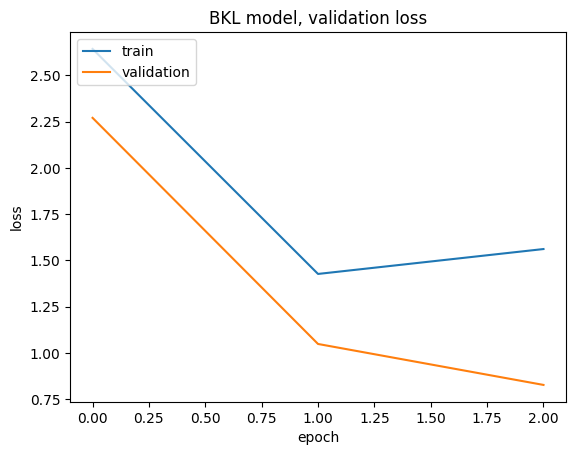

Found 306 validated image filenames belonging to 2 classes.
Found 306 validated image filenames belonging to 2 classes.


/Users/demo/anaconda3/envs/COGS118B_WI24/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/3


/Users/demo/anaconda3/envs/COGS118B_WI24/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
2024-03-20 15:59:46.357275: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:444: Filling up shuffle buffer (this may take a while): 3 of 8
2024-03-20 15:59:56.246475: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


5/5 ━━━━━━━━━━━━━━━━━━━━ 117s 19s/step - accuracy: 0.4820 - loss: 4.7366 - val_accuracy: 0.3758 - val_loss: 32.0807
Epoch 2/3


2024-03-20 16:01:40.724614: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:444: Filling up shuffle buffer (this may take a while): 3 of 8
2024-03-20 16:01:49.922300: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


5/5 ━━━━━━━━━━━━━━━━━━━━ 101s 17s/step - accuracy: 0.6113 - loss: 3.8284 - val_accuracy: 0.3725 - val_loss: 12.1810
Epoch 3/3


2024-03-20 16:03:17.009273: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:444: Filling up shuffle buffer (this may take a while): 2 of 8
2024-03-20 16:03:30.692806: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:444: Filling up shuffle buffer (this may take a while): 5 of 8
2024-03-20 16:03:30.693866: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


5/5 ━━━━━━━━━━━━━━━━━━━━ 103s 18s/step - accuracy: 0.6085 - loss: 2.6183 - val_accuracy: 0.3758 - val_loss: 9.6303
Found 96 validated image filenames belonging to 2 classes.


/Users/demo/anaconda3/envs/COGS118B_WI24/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


3/3 ━━━━━━━━━━━━━━━━━━━━ 10s 3s/step - accuracy: 0.6875 - loss: 4.9215 
Test Loss: 8.079611778259277, Test Accuracy: 0.5


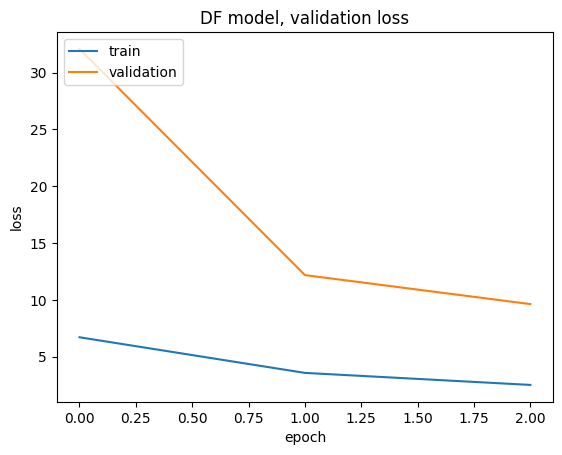

Found 839 validated image filenames belonging to 2 classes.
Found 839 validated image filenames belonging to 2 classes.


/Users/demo/anaconda3/envs/COGS118B_WI24/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/3


/Users/demo/anaconda3/envs/COGS118B_WI24/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
2024-03-20 16:05:31.794868: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:464: Filling up shuffle buffer (this may take a while): 2 of 8
2024-03-20 16:05:42.715425: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:464: Filling up shuffle buffer (this may take a while): 5 of 8
2024-03-20 16:05:52.825870: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:464: Filling up shuffle buffer (this may take a while): 7 of 8
2024-03-20 16:05:57.940564: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer 

14/14 ━━━━━━━━━━━━━━━━━━━━ 270s 17s/step - accuracy: 0.5094 - loss: 4.2504 - val_accuracy: 0.3754 - val_loss: 16.3434
Epoch 2/3


2024-03-20 16:09:56.783647: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:464: Filling up shuffle buffer (this may take a while): 2 of 8
2024-03-20 16:10:06.964102: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:464: Filling up shuffle buffer (this may take a while): 4 of 8
2024-03-20 16:10:17.409880: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:464: Filling up shuffle buffer (this may take a while): 6 of 8
2024-03-20 16:10:27.653036: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


14/14 ━━━━━━━━━━━━━━━━━━━━ 252s 15s/step - accuracy: 0.6117 - loss: 2.3278 - val_accuracy: 0.3945 - val_loss: 9.9430
Epoch 3/3


2024-03-20 16:14:13.078863: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:464: Filling up shuffle buffer (this may take a while): 3 of 8
2024-03-20 16:14:32.786291: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:464: Filling up shuffle buffer (this may take a while): 7 of 8
2024-03-20 16:14:37.836978: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


14/14 ━━━━━━━━━━━━━━━━━━━━ 259s 16s/step - accuracy: 0.5838 - loss: 1.7856 - val_accuracy: 0.6234 - val_loss: 1.7824
Found 208 validated image filenames belonging to 2 classes.


/Users/demo/anaconda3/envs/COGS118B_WI24/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


7/7 ━━━━━━━━━━━━━━━━━━━━ 24s 3s/step - accuracy: 0.2633 - loss: 3.1677
Test Loss: 2.044604778289795, Test Accuracy: 0.504807710647583


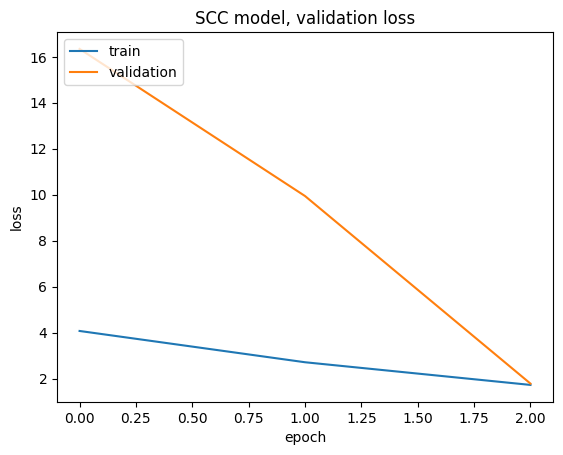

Found 4264 validated image filenames belonging to 2 classes.
Found 4264 validated image filenames belonging to 2 classes.


/Users/demo/anaconda3/envs/COGS118B_WI24/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/3


/Users/demo/anaconda3/envs/COGS118B_WI24/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
2024-03-20 16:19:10.888458: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:484: Filling up shuffle buffer (this may take a while): 2 of 8
2024-03-20 16:19:20.901452: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:484: Filling up shuffle buffer (this may take a while): 4 of 8
2024-03-20 16:19:31.142447: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:484: Filling up shuffle buffer (this may take a while): 6 of 8
2024-03-20 16:19:41.315733: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer 

67/67 ━━━━━━━━━━━━━━━━━━━━ 1204s 17s/step - accuracy: 0.6244 - loss: 3.7733 - val_accuracy: 0.3970 - val_loss: 7.9301
Epoch 2/3


2024-03-20 16:39:12.185636: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:484: Filling up shuffle buffer (this may take a while): 2 of 8
2024-03-20 16:39:23.199624: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:484: Filling up shuffle buffer (this may take a while): 4 of 8
2024-03-20 16:39:33.718677: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:484: Filling up shuffle buffer (this may take a while): 6 of 8
2024-03-20 16:39:44.266322: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


67/67 ━━━━━━━━━━━━━━━━━━━━ 1199s 17s/step - accuracy: 0.6815 - loss: 1.5625 - val_accuracy: 0.7235 - val_loss: 0.6730
Epoch 3/3


2024-03-20 16:59:11.207365: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:484: Filling up shuffle buffer (this may take a while): 2 of 8
2024-03-20 16:59:21.693024: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:484: Filling up shuffle buffer (this may take a while): 4 of 8
2024-03-20 16:59:31.870345: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:484: Filling up shuffle buffer (this may take a while): 6 of 8
2024-03-20 16:59:41.933154: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


67/67 ━━━━━━━━━━━━━━━━━━━━ 1156s 17s/step - accuracy: 0.7146 - loss: 1.0659 - val_accuracy: 0.6358 - val_loss: 0.9492
Found 1316 validated image filenames belonging to 2 classes.


/Users/demo/anaconda3/envs/COGS118B_WI24/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


42/42 ━━━━━━━━━━━━━━━━━━━━ 135s 3s/step - accuracy: 0.2099 - loss: 2.0361
Test Loss: 1.2561308145523071, Test Accuracy: 0.5151975750923157


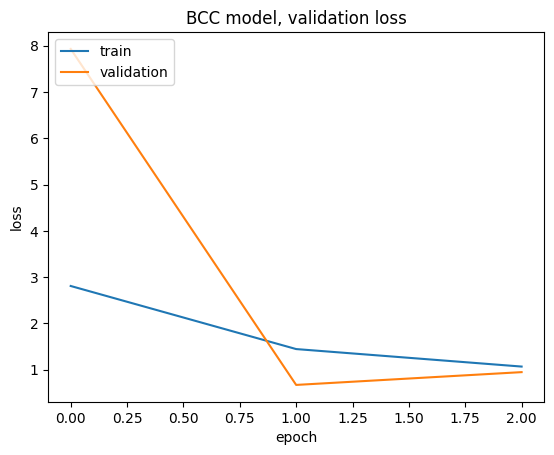

Found 306 validated image filenames belonging to 2 classes.
Found 306 validated image filenames belonging to 2 classes.


/Users/demo/anaconda3/envs/COGS118B_WI24/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/3


/Users/demo/anaconda3/envs/COGS118B_WI24/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
2024-03-20 17:21:01.473656: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:504: Filling up shuffle buffer (this may take a while): 2 of 8
2024-03-20 17:21:15.505986: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:504: Filling up shuffle buffer (this may take a while): 5 of 8
2024-03-20 17:21:15.506914: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


5/5 ━━━━━━━━━━━━━━━━━━━━ 113s 19s/step - accuracy: 0.5265 - loss: 5.5656 - val_accuracy: 0.3758 - val_loss: 37.3269
Epoch 2/3


2024-03-20 17:22:51.963248: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:504: Filling up shuffle buffer (this may take a while): 2 of 8
2024-03-20 17:23:02.628737: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:504: Filling up shuffle buffer (this may take a while): 4 of 8
2024-03-20 17:23:06.557170: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


5/5 ━━━━━━━━━━━━━━━━━━━━ 102s 17s/step - accuracy: 0.6509 - loss: 3.5500 - val_accuracy: 0.6144 - val_loss: 4.5880
Epoch 3/3


2024-03-20 17:24:34.683060: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:504: Filling up shuffle buffer (this may take a while): 2 of 8
2024-03-20 17:24:44.878675: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:504: Filling up shuffle buffer (this may take a while): 4 of 8
2024-03-20 17:24:48.720801: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


5/5 ━━━━━━━━━━━━━━━━━━━━ 105s 18s/step - accuracy: 0.7024 - loss: 2.3439 - val_accuracy: 0.7026 - val_loss: 1.9090
Found 124 validated image filenames belonging to 2 classes.


/Users/demo/anaconda3/envs/COGS118B_WI24/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


4/4 ━━━━━━━━━━━━━━━━━━━━ 13s 3s/step - accuracy: 0.7697 - loss: 0.6902
Test Loss: 0.8774533271789551, Test Accuracy: 0.7419354915618896


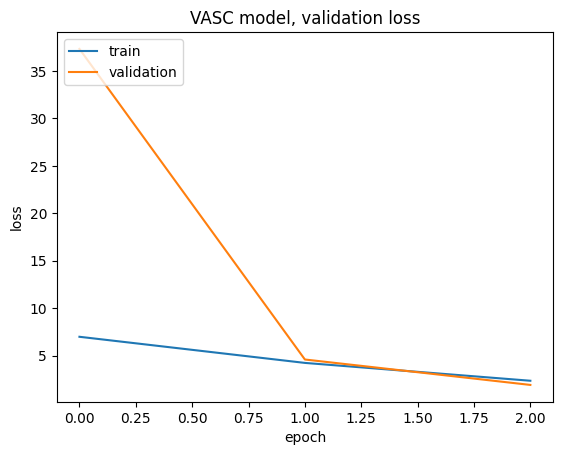

In [79]:
for i in tables.keys():
    hist_1, mdl_1 = create_model(tables[i], str(i) + " model, validation", 3)
    test_generator = datagen.flow_from_dataframe(
        dataframe=tables_test[i],
        directory=None,
        x_col='file',
        y_col='label',
        seed=42,
        shuffle=False,
        class_mode="binary",
        target_size=(512, 512)
        )
    eval_result = mdl_1.evaluate(test_generator)
    print(f"Test Loss: {eval_result[0]}, Test Accuracy: {eval_result[1]}")
    plot_history(hist_1, str(i) + " model, validation loss")